## Set Up Dependencies and Data


In [1]:
import gc
import multiprocessing
import os
import random


import alifedata_phyloinformatics_convert as apc
from ete4 import Tree
from ete4.treeview import TreeStyle
from IPython.display import Image
from hstrat._auxiliary_lib import (
    alifestd_find_leaf_ids,
    alifestd_collapse_unifurcations,
    alifestd_prune_extinct_lineages_asexual,
    alifestd_sum_origin_time_deltas_asexual,
    alifestd_to_working_format,
)
import joblib
from keyname import keyname as kn
import more_itertools as mit
import numpy as np
import pandas as pd
import seaborn as sns
from teeplot import teeplot as tp
from tqdm.notebook import tqdm


In [2]:
df = pd.read_parquet(
    "https://osf.io/r2a7t/download",
    engine="pyarrow",
)


## Reproducibility


In [3]:
%load_ext watermark
%watermark -iwbmuvg -iv


Last updated: 2024-04-13T22:51:33.375227+00:00

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.20.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.5.0-1017-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

Git hash: b0998f95b3c94c5cdede2b256737ada8dbea07e1

Git branch: HEAD

joblib                            : 1.3.2
keyname                           : 0.6.0
more_itertools                    : 10.2.0
pandas                            : 1.5.3
numpy                             : 1.23.5
alifedata_phyloinformatics_convert: 0.16.2
teeplot                           : 1.0.1
seaborn                           : 0.13.2

Watermark: 2.4.3



In [4]:
df.head()


,index,id,ancestor_list,origin_time,taxon_label,ancestor_id,popSize,replicate,globalSeed,nCycle,genomeFlavor,dataSource
0,0,0,[none],0.000000,Root,0,10000,85948d9b-a66b-4840-a0ae-dfbbd5ebe7b1,4.0,1000000.0,genome_purifyingonly,https://osf.io/hm5wa/download
1,1,1,[0],87380.666667,Inner+r=0+d=A+uid=eL-uJQUw0PBAnxNHDhrvE,0,10000,85948d9b-a66b-4840-a0ae-dfbbd5ebe7b1,4.0,1000000.0,genome_purifyingonly,https://osf.io/hm5wa/download
2,2,2,[0],87380.666667,Inner+r=0+d=B+uid=1TDH_WoJTn1CzhaAR_evg,0,10000,85948d9b-a66b-4840-a0ae-dfbbd5ebe7b1,4.0,1000000.0,genome_purifyingonly,https://osf.io/hm5wa/download
3,7,7,[1],388356.074074,Inner+r=393215+d=B+uid=1v5ktyenGFmEudpamzswb,1,10000,85948d9b-a66b-4840-a0ae-dfbbd5ebe7b1,4.0,1000000.0,genome_purifyingonly,https://osf.io/hm5wa/download
4,8,8,[1],388356.074074,Inner+r=393215+d=B+uid=DBHHhpwrGrsEOrdWN9e79t,1,10000,85948d9b-a66b-4840-a0ae-dfbbd5ebe7b1,4.0,1000000.0,genome_purifyingonly,https://osf.io/hm5wa/download


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498769 entries, 0 to 498768
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   index          498769 non-null  int64  
 1   id             498769 non-null  int64  
 2   ancestor_list  498769 non-null  object 
 3   origin_time    498769 non-null  float64
 4   taxon_label    498769 non-null  object 
 5   ancestor_id    498769 non-null  int64  
 6   popSize        498769 non-null  int64  
 7   replicate      498769 non-null  object 
 8   globalSeed     498769 non-null  float64
 9   nCycle         498769 non-null  float64
 10  genomeFlavor   498769 non-null  object 
 11  dataSource     498769 non-null  object 
dtypes: float64(3), int64(4), object(5)
memory usage: 45.7+ MB


In [6]:
df.describe()


,index,id,origin_time,ancestor_id,popSize,globalSeed,nCycle
count,498769.000000,498769.000000,498769.000000,498769.000000,498769.000000,498769.000000,498769.000000
mean,68361.577323,68361.577323,855428.293309,64836.728887,253794.737043,2.500145,988608.554261
std,40481.487483,40481.487483,97973.638427,40272.559868,229116.644381,1.118192,100610.916031
min,0.000000,0.000000,0.000000,0.000000,400.000000,1.000000,100000.000000
25%,32486.000000,32486.000000,823235.000000,28920.000000,10000.000000,1.000000,1000000.000000
50%,68569.000000,68569.000000,826247.000000,64110.000000,250000.000000,3.000000,1000000.000000
75%,102503.000000,102503.000000,907814.488981,98177.000000,562500.000000,4.000000,1000000.000000
max,152643.000000,152643.000000,916579.000000,152513.000000,562500.000000,4.000000,1000000.000000


In [7]:
joblib.hash(df)


'ccf4cc09fb27f15c88bc0b4d108075ea'

In [8]:
df.dtypes


index              int64
id                 int64
ancestor_list     object
origin_time      float64
taxon_label       object
ancestor_id        int64
popSize            int64
replicate         object
globalSeed       float64
nCycle           float64
genomeFlavor      object
dataSource        object
dtype: object

## Helper Functions


In [9]:
def logify_phylo(phylo_df):
    phylo_df = phylo_df.copy()
    phylo_df["log time ago"] = np.log(
        phylo_df["origin_time"].max() - phylo_df["origin_time"] + 1
    )
    phylo_df["origin_time"] = (
        phylo_df["log time ago"].max() - phylo_df["log time ago"]
    )
    return phylo_df


## Calculate Phylometrics


In [10]:
# records = []
# for replicate, tree_df in tqdm(df.groupby("replicate")):
#     tree_df = tree_df.reset_index(drop=True)
#     tree_df = alifestd_to_working_format(tree_df)
#     attrs = {
#         col: mit.one(tree_df[col].unique())
#         for col in tree_df.columns
#         if len(tree_df[col].unique()) == 1 and col not in ["dataSource"]
#     }

#     records.append(
#         {
#             **attrs,
#             "replicate": replicate,
#             "metric": "sum branch lengths",
#             "value": alifestd_sum_origin_time_deltas_asexual(tree_df),
#         },
#     )

#     def calc_mean_evolutionary_distinctiveness(tdf: pd.DataFrame) -> float:
#         tree = apc.RosettaTree(tdf).as_phylotrack
#         return tree.get_mean_evolutionary_distinctiveness(
#             tdf["origin_time"].max()
#         )

#     def get_mean_evolutionary_distinctiveness(tdf: pd.DataFrame) -> float:
#         with multiprocessing.Pool(1) as pool:
#             result = pool.map(calc_mean_evolutionary_distinctiveness, [tdf])
#             return result[0]

#     records.append(
#         {
#             **attrs,
#             "replicate": replicate,
#             "metric": "mean evolutionary distinctiveness",
#             "value": get_mean_evolutionary_distinctiveness(tree_df),
#         },
#     )
#     break

# dfmetrics = pd.DataFrame.from_records(records)


## Plot Phylometrics


In [11]:
# fil = dfmetrics[
#     (dfmetrics["nCycle"] == 1e6)
#     & (dfmetrics["popSize"] >= 10000)
#     & (
#         dfmetrics["metric"].isin(
#             ["sum branch lengths", "mean evolutionary distinctiveness"],
#         )
#     )
# ].copy()
# fil["num PEs (10k)"] = (fil["popSize"] / 1e4).astype(int)
# fil["metric"] = fil["metric"].apply(
#     lambda x: x.replace(" ", "\n").replace("\n", " ", 1)
# )

# fil["regime"] = fil["genomeFlavor"].map(
#     {
#         "genome_purifyingplus": "adaptive",
#         "genome_purifyingonly": "purifying",
#     },
# )

# tp.tee(
#     sns.catplot,
#     fil,
#     y="value",
#     x="num PEs (10k)",
#     hue="regime",
#     col="metric",
#     sharex=True,
#     sharey=False,
#     kind="swarm",
#     height=2,
#     aspect=1.2,
#     teeplot_postprocess="teed.set_titles('{col_name}')",
# )

# del dfmetrics
# del fil


## Plotted Reconstructed Tree


  0%|          | 0/48 [00:00<?, ?it/s]

Wrote file:

outplots/log/genomeFlavor=genome_purifyingplus+globalSeed=4.0+nCycle=1000000.0+popSize=1600+replicate=061eb8e9-0b71-46d4-8639-99ff955b45a0+ext=.pdf

Wrote file:

/tmp/render.png

genomeFlavor=genome_purifyingplus+globalSeed=4.0+nCycle=1000000.0+popSize=1600+replicate=061eb8e9-0b71-46d4-8639-99ff955b45a0+ext=.pdf


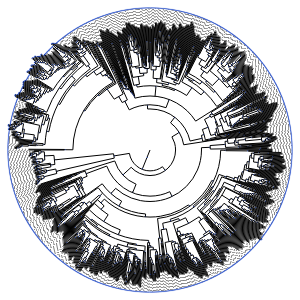

In [12]:
os.makedirs("outplots/log", exist_ok=True)
for replicate, tree_df in tqdm(df.groupby("replicate")):
    tree_df = alifestd_to_working_format(tree_df.reset_index(drop=True))

    tips = alifestd_find_leaf_ids(tree_df)
    n_downsample = 1000
    kept = random.sample(tips, min(n_downsample, len(tips)))
    tree_df["extant"] = tree_df["id"].isin(kept)

    tree_df = alifestd_prune_extinct_lineages_asexual(tree_df)
    tree_df = alifestd_collapse_unifurcations(tree_df)

    tree_df = logify_phylo(tree_df)  # log scale branches

    attrs = {
        col: mit.one(tree_df[col].unique())
        for col in tree_df.columns
        if len(tree_df[col].unique()) == 1 and col not in ["dataSource"]
    }
    attrs["ext"] = ".pdf"

    tree_df = tree_df.drop("taxon_label", axis=1).copy()
    tree_df["taxon_label"] = tree_df["id"]

    outname = kn.pack(attrs)
    def do_render(tdf: pd.DataFrame):
        t = Tree(apc.RosettaTree(tdf).to_newick())
        t.to_ultrametric()

        ts = TreeStyle()
        ts.mode = "c"
        ts.arc_start = -180  # 0 degrees = 3 o'clock
        ts.arc_span = 360
        ts.show_leaf_name = False
        ts.show_scale = False

        t.render(f"outplots/log/{outname}", tree_style=ts, w=1, units="in")
        t.render("/tmp/render.png", tree_style=ts, w=1, units="in", dpi=300)

    with multiprocessing.Pool(1) as pool:
        pool.map(do_render, [tree_df])

    print(outname)
    display(Image(filename="/tmp/render.png",width=300))
    gc.collect()
    break


  0%|          | 0/48 [00:00<?, ?it/s]

Wrote file:

outplots/linear/genomeFlavor=genome_purifyingplus+globalSeed=4.0+nCycle=1000000.0+popSize=1600+replicate=061eb8e9-0b71-46d4-8639-99ff955b45a0+ext=.pdf

Wrote file:

/tmp/render.png

genomeFlavor=genome_purifyingplus+globalSeed=4.0+nCycle=1000000.0+popSize=1600+replicate=061eb8e9-0b71-46d4-8639-99ff955b45a0+ext=.pdf


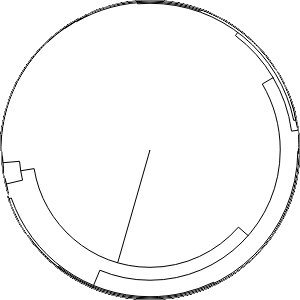

In [13]:
os.makedirs("outplots/linear", exist_ok=True)
for replicate, tree_df in tqdm(df.groupby("replicate")):
    tree_df = alifestd_to_working_format(tree_df.reset_index(drop=True))

    tips = alifestd_find_leaf_ids(tree_df)
    n_downsample = 1000
    kept = random.sample(tips, min(n_downsample, len(tips)))
    tree_df["extant"] = tree_df["id"].isin(kept)

    tree_df = alifestd_prune_extinct_lineages_asexual(tree_df)
    tree_df = alifestd_collapse_unifurcations(tree_df)

    attrs = {
        col: mit.one(tree_df[col].unique())
        for col in tree_df.columns
        if len(tree_df[col].unique()) == 1 and col not in ["dataSource"]
    }
    attrs["ext"] = ".pdf"

    tree_df = tree_df.drop("taxon_label", axis=1).copy()
    tree_df["taxon_label"] = tree_df["id"]

    outname = kn.pack(attrs)
    def do_render(tdf: pd.DataFrame):
        t = Tree(apc.RosettaTree(tdf).to_newick())

        ts = TreeStyle()
        ts.mode = "c"
        ts.arc_start = -180  # 0 degrees = 3 o'clock
        ts.arc_span = 360
        ts.show_leaf_name = False
        ts.show_scale = False

        t.render(f"outplots/linear/{outname}", tree_style=ts, w=1, units="in")
        t.render("/tmp/render.png", tree_style=ts, w=1, units="in", dpi=300)

    with multiprocessing.Pool(1) as pool:
        pool.map(do_render, [tree_df])

    print(outname)
    display(Image(filename="/tmp/render.png",width=300))
    gc.collect()
    break
